* Done By: Mohammed Abu Amira.
* Linkedin: https://www.linkedin.com/in/mohamedabuamira

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys
import shutil
import os
import glob
import cv2
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from keras import layers
from keras.layers import Dropout , Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn.utils import shuffle

# Download dataset from Kaggle

In [2]:
# Download the dataset from Kaggle

from google.colab import files
files.upload()                             # upload kaggle.json form my account


# The Kaggle API client expects the json file to be in ~/.kaggle folder
# so let’s create a new folder and move it inside
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


#!kaggle datasets download -d rounakbanik/the-movies-dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

!ls        # see the floders in dictory



Saving kaggle.json to kaggle.json
 97% 653M/675M [00:13<00:00, 50.1MB/s]
100% 675M/675M [00:13<00:00, 52.0MB/s]
cell-images-for-detecting-malaria.zip  kaggle.json  sample_data


In [3]:
# extract the files

import zipfile
zip_ref = zipfile.ZipFile("cell-images-for-detecting-malaria.zip", "r")
zip_ref.extractall("cell images")
zip_ref.close()

!ls

'cell images'				 kaggle.json
 cell-images-for-detecting-malaria.zip	 sample_data


In [4]:
#!rm -rf files       #delet folder
# Delet the zip file
!rm cell-images-for-detecting-malaria.zip  


In [5]:
print(os.listdir())

['.config', 'kaggle.json', 'cell images', 'sample_data']


In [6]:
print(os.listdir("cell images/cell_images/"))

['Parasitized', 'cell_images', 'Uninfected']


In [7]:
# delet the unnecessary folder (cell_images), its Duplicate folder when download dataset from Kaggle


# location  
location = "cell images/cell_images/"
    
# directory  
dir = "cell_images"
    
# path  
path = os.path.join(location, dir)  
    
# removing directory  
shutil.rmtree(path, ignore_errors = False) 

# Spilt the data to train and validation

To make evey thing easir, I will spilt the directory to train and validation.

In [8]:
!pip install split-folders   #install package to spilt directories


In [9]:
import splitfolders

DATA_DIR="cell images/cell_images"
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(DATA_DIR , output="cell images data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 27560 files [00:04, 6246.89 files/s]


In [10]:
# Now delet the original folder 

# directory  
dir = "cell images/cell_images"
    
# path  
path = os.path.join(location, dir)  
    
# removing directory  
shutil.rmtree(dir, ignore_errors = False) 

In [2]:
# CONSTANTS FOR DIRECTORIES
TRAIN_DIR = "cell images data/train/"
VAL_DIR = "cell images data/val/"

# CONSTANTS FOR IMAGE PARAMETERS
TARGET_W = 128 # pixels
TARGET_H = 128  # pixels


BATCH_SIZE_TRAIN = 32
#BATCH_SIZE_TEST = 64 
BATCH_SIZE_VALID = 32
NORMALIZER = 1./255


In [3]:
PARASITIZED_TRAIN_DIR=glob.glob(TRAIN_DIR + "Parasitized/*.png")
UNINFECTED_TRAIN_DIR = glob.glob(TRAIN_DIR + "Uninfected/*.png")

In [4]:
# print one image file

print(PARASITIZED_TRAIN_DIR[0])
print(UNINFECTED_TRAIN_DIR[0])

cell images data/train/Parasitized/C136P97ThinF_IMG_20151005_141803_cell_118.png
cell images data/train/Uninfected/C184P145ThinF_IMG_20151203_103637_cell_61.png


# Display the orginal images

In [5]:
# Define a function to display images

def display_six_images(image_dir, title=None):
  plt.figure(figsize=(12,12))
  for i in range(6):
    plt.subplot(3,3 ,1+i)
    img=plt.imread(image_dir[i])
    plt.imshow(img)
    plt.title(title)
    plt.tight_layout()
  plt.show

###  Parasitized Images

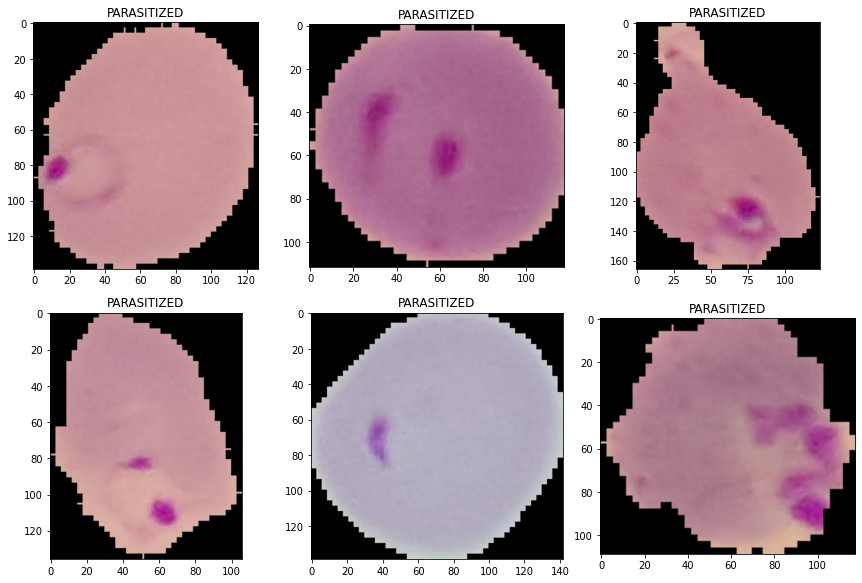

In [6]:
display_six_images(PARASITIZED_TRAIN_DIR, "PARASITIZED")

### Uninfected Images

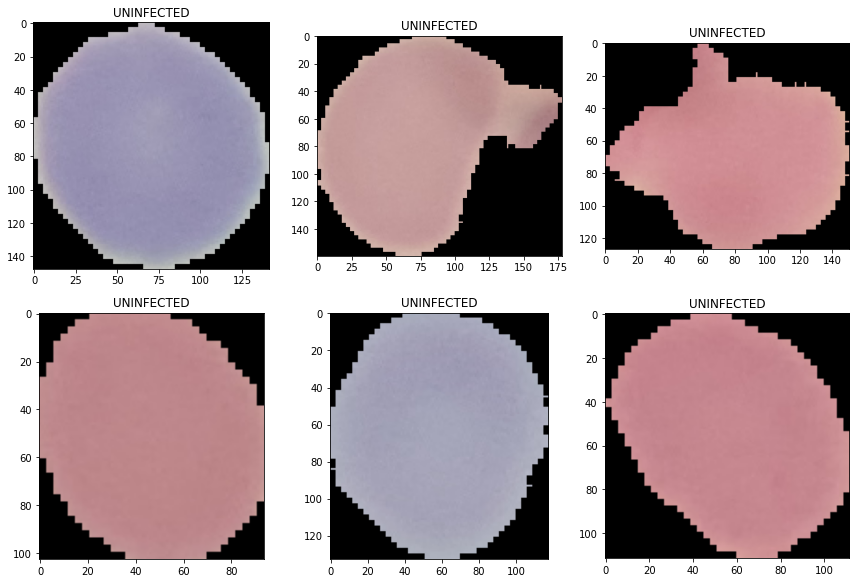

In [7]:
display_six_images(UNINFECTED_TRAIN_DIR, "UNINFECTED")

**You can observe a small clot inside the cellular image for infected while for the uninfected the cellular image is clean without any clots.**

# Creating processed datasets


In [25]:
train_datagen = ImageDataGenerator(
        rescale=NORMALIZER,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        fill_mode = 'nearest',
        zoom_range = 0.3,
        rotation_range = 30,
        validation_split=None)


train_batches_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(TARGET_H, TARGET_W),
        batch_size=BATCH_SIZE_TRAIN,
        class_mode='binary',
        shuffle=True)


Found 22046 images belonging to 2 classes.


In [26]:
# Output of Train Generators
for data_batch, label_batch in train_batches_generator:
    print('Data Batch Shape = {}'.format(data_batch.shape))
    print('Labels Batch Shape = {}'.format(label_batch.shape))
    break

# lenght
print("Number of baches in Train data:", len(train_batches_generator))

Data Batch Shape = (32, 128, 128, 3)
Labels Batch Shape = (32,)
Number of baches in Train data: 689


In [27]:
class_names = train_batches_generator.class_indices
print(class_names)

{'Parasitized': 0, 'Uninfected': 1}


In [28]:
# list out keys and values separately 
labels_name = list(class_names.keys()) 
labels = list(class_names.values())
print(labels_name)
print(labels)

['Parasitized', 'Uninfected']
[0, 1]


In [29]:
labels_name[labels.index(0)], labels_name[labels.index(1)]

('Parasitized', 'Uninfected')

In [30]:
images, labels_ = next(train_batches_generator)  # Extracting image matrixes and labels for one batch

#check image size
print(images[0].shape)


# chech dimensions
print("Max: {} \nMin: {}".format(images[0].max(),images[0].min()))

(128, 128, 3)
Max: 0.8168301582336426 
Min: 0.0


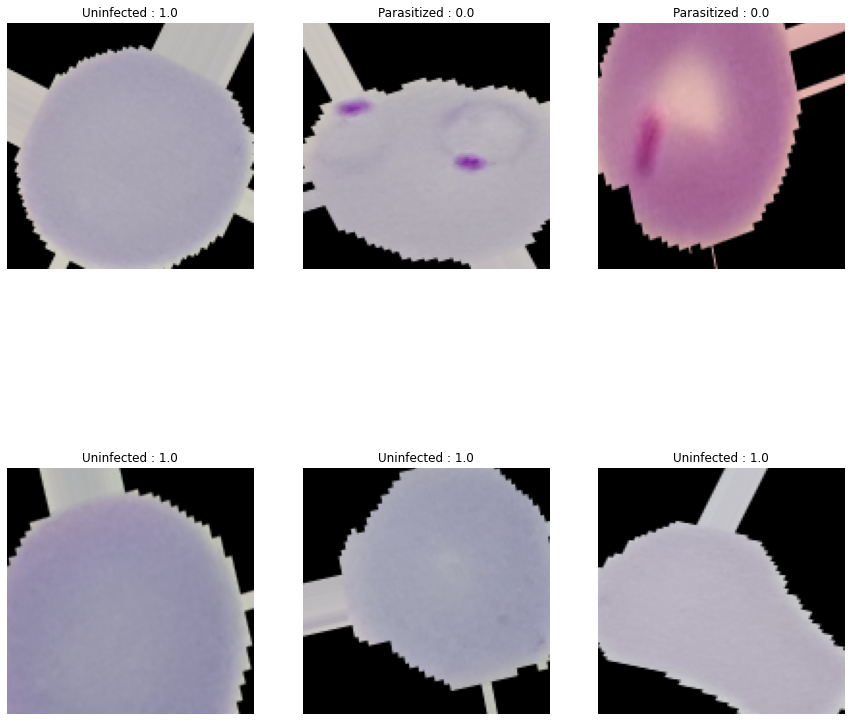

In [31]:
plt.figure(figsize=(15,15))
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(images[i])
  plt.title("{} : {}".format(labels_name[labels.index(labels_[i])], labels_[i]))
  plt.axis("off")

In [32]:
val_datagen = ImageDataGenerator(rescale=NORMALIZER)

validation_batches_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(TARGET_H, TARGET_W),
        batch_size=BATCH_SIZE_VALID,
        class_mode='binary',
        shuffle=False)

Found 5512 images belonging to 2 classes.


In [33]:
# Output of Val Generators
for data_batch, label_batch in validation_batches_generator:
    print('Data Batch Shape = {}'.format(data_batch.shape))
    print('Labels Batch Shape = {}'.format(label_batch.shape))
    break

# lenght
print("Number of baches in Val data:", len(validation_batches_generator))

Data Batch Shape = (32, 128, 128, 3)
Labels Batch Shape = (32,)
Number of baches in Val data: 173


**To Now All are GOOD**

# Create CNN model 

In [34]:
def CNN_model():

    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (TARGET_H, TARGET_W, 3))) # shape 128*128*3
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Conv Block 2
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Conv Block 3
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Conv Block 4
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Conv Block 5
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Out
    model.add(Dense(2, activation = 'softmax'))

    return model

In [35]:
model=CNN_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)       

In [36]:
# Set a learning rate annealer
learning_rate_redcuing=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience=3,
                                         verbose=1,
                                         factor=0.3,
                                         min_lr=0.00001)

In [37]:
#set optimizer
opt= tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [38]:
#set loss
loss_fn = keras.losses.SparseCategoricalCrossentropy()

In [39]:
#compile the model
model.compile(loss = loss_fn, optimizer = opt, metrics = ['accuracy'])

In [40]:
# callbacks
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)


In [41]:
model.fit_generator(train_batches_generator,
                              steps_per_epoch = len(train_batches_generator),
                              epochs =15,
                              validation_data = validation_batches_generator,
                              validation_steps=len(validation_batches_generator),
                              callbacks=learning_rate_redcuing)
                              
                              


Epoch 1/15
689/689 [==============================] - 118s 171ms/step - loss: 0.5031 - accuracy: 0.7953 - val_loss: 0.2077 - val_accuracy: 0.9327
Epoch 2/15
689/689 [==============================] - 119s 173ms/step - loss: 0.2726 - accuracy: 0.9057 - val_loss: 0.1833 - val_accuracy: 0.9399
Epoch 3/15
689/689 [==============================] - 118s 171ms/step - loss: 0.2334 - accuracy: 0.9218 - val_loss: 0.1731 - val_accuracy: 0.9367
Epoch 5/15
689/689 [==============================] - 118s 171ms/step - loss: 0.2375 - accuracy: 0.9179 - val_loss: 0.1713 - val_accuracy: 0.9447
Epoch 6/15
689/689 [==============================] - 119s 172ms/step - loss: 0.2318 - accuracy: 0.9217 - val_loss: 0.1583 - val_accuracy: 0.9488
Epoch 7/15
689/689 [==============================] - 119s 172ms/step - loss: 0.2266 - accuracy: 0.9221 - val_loss: 0.1596 - val_accuracy: 0.9490
Epoch 8/15
689/689 [==============================] - 118s 171ms/step - loss: 0.2267 - accuracy: 0.9218 - val_loss: 0.2163 -

# Evaluate the model

## Training and validation curves

In [42]:
import matplotlib.pyplot as plt 
from pylab import rcParams

# Plot Result Graph for Accuracy, Loss and Validation
# Source: https://github.com/vb100/Pneumonia-X-Rays-of-Human-Lungs-AI-project/blob/master/vb100_utils.py
def plot_model_result(model):
	'''
		-- model : Keras model.
	'''

	rcParams['figure.figsize'] = 14, 4 # Set plot size

	# Plot #1

	y1 = model.history.history['val_accuracy']
	y2 = model.history.history['accuracy']

	_ = plt.title('Model Results', family='DejaVu Sans', fontsize=15)

	_ = plt.plot(y1, 
		color='blue', linewidth=1.5, marker='D', markersize=5,
		label='Validation acc.')
	_ = plt.plot(y2, 
		color='#9999FF', linewidth=1.5, marker='D', markersize=5,
		label='Training acc.')

	_ = plt.xlabel('Epochs', family='DejaVu Sans', fontsize=10)
	_ = plt.ylabel('Score', family='DejaVu Sans', fontsize=10)

	_ = plt.yticks(np.arange(0., 1.25, 0.1),
				   family='DejaVu Sans', fontsize=10)

	if len(model.history.history['accuracy']) < 51:
		_ = plt.xticks(np.arange(0, len(model.history.history['accuracy']), 1),
					   family='DejaVu Sans', fontsize=10)

	_ = plt.ylim((0., 1.))

	_ = plt.fill_between(np.arange(0, len(model.history.history['accuracy']), 1),
						 model.history.history['accuracy'], 0,
						 color = '#cccccc', alpha=0.5)

	_ = plt.grid(which='major', color='#cccccc', linewidth=0.5)
	_ = plt.legend(loc='best', shadow=True)
	_ = plt.margins(0.02)

	_ = plt.show()

	# Plot #2
	_ = plt.clf()

	_ = plt.plot(model.history.history['val_loss'], 
		color='red', linewidth=1.5, marker='D', markersize=5,
		label='Validation loss')
	_ = plt.plot(model.history.history['loss'], 
		color='#FF7F7F', linewidth=1.5, marker='D', markersize=5,
		label='Loss')

	_ = plt.xlabel('Epochs', family='DejaVu Sans', fontsize=10)
	_ = plt.ylabel('Loss score', family='DejaVu Sans', fontsize=10)

	if len(model.history.history['accuracy']) < 51:
		_ = plt.xticks(np.arange(0, len(model.history.history['accuracy']), 1),
					   family='DejaVu Sans', fontsize=10)
	_ = plt.yticks(family='DejaVu Sans', fontsize=10)

	_ = plt.grid(which='major', color='#cccccc', linewidth=0.5)
	_ = plt.legend(loc='best', shadow=True)
	_ = plt.margins(0.02)

	_ = plt.show()

	return None


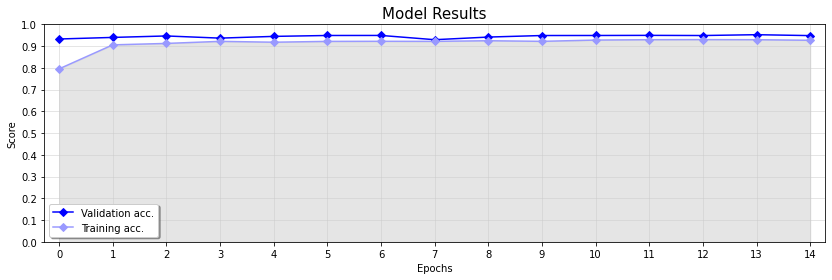

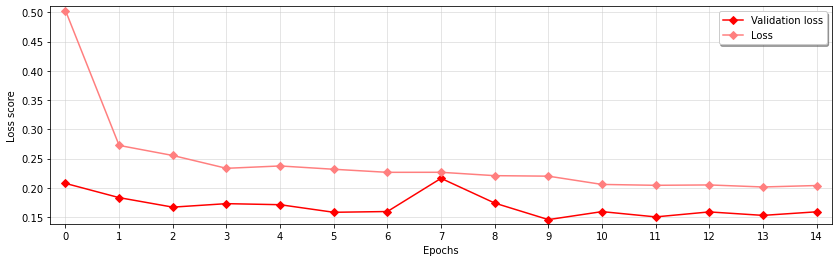

In [43]:
plot_model_result(model)

In [44]:
# reset
validation_batches_generator.reset()
# Evaluate the model on val data
predictions = model.evaluate_generator(validation_batches_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [45]:
print(f"The losses of validation data: {predictions[0]}")
print(f"The accuracy of validation data: {predictions[1]}")

The losses of validation data: 0.15911699831485748
The accuracy of validation data: 0.9482946395874023


## Predictions and confusion matrix

In [46]:
# reset
validation_batches_generator.reset()

pred= model.predict_generator(validation_batches_generator)

predicted_label_indices=np.argmax(pred, axis=1)     # Get labels for all predictions

labels=(validation_batches_generator.class_indices) # {'Parasitized': 0, 'Uninfected': 1}

labels2=dict((v,k) for k,v in labels.items())       # {0: 'Parasitized', 1: 'Uninfected'}

predictions=[labels2[k] for k in predicted_label_indices]   # Get label names that predicted 


Instructions for updating:
Please use Model.predict, which supports generators.


In [47]:
print(pred[:][:5])
print(predicted_label_indices[:5])
print(labels)
print(predictions[:5])

[[9.9822420e-01 1.7758142e-03]
 [9.9992597e-01 7.4031756e-05]
 [9.9545032e-01 4.5496579e-03]
 [9.9612707e-01 3.8729785e-03]
 [9.5359462e-01 4.6405397e-02]]
[0 0 0 0 0]
{'Parasitized': 0, 'Uninfected': 1}
['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized']


In [48]:
labels_names= np.asanyarray(labels_name)    #Get label names
labels_names

array(['Parasitized', 'Uninfected'], dtype='<U11')

In [49]:
val_labels=[]
for i in range(len(validation_batches_generator)):
  _,label_batch = next(validation_batches_generator)
  val_labels.extend(label_batch.tolist())

In [50]:
len(val_labels)

5512

In [51]:
val_labels[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [52]:
val_labels=np.asarray(val_labels)
val_labels = val_labels.astype(int) # Get labels for all val data
val_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [53]:
true_label_names=labels_names[val_labels] # # Get label names that opposites to  val_labels
true_label_names[:10]

array(['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized'], dtype='<U11')

In [55]:
# no. of True classifed labels in that batch
print("The Number of Successfully classified Images:", sum(val_labels==predicted_label_indices))


The Number of Successfully classified Images: 5227


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[Text(69.0, 0.5, 'True label'),
 Text(0.5, 117.59999999999997, 'Predicted label'),
 Text(0.5, 1.0, 'Confusion Matrix')]

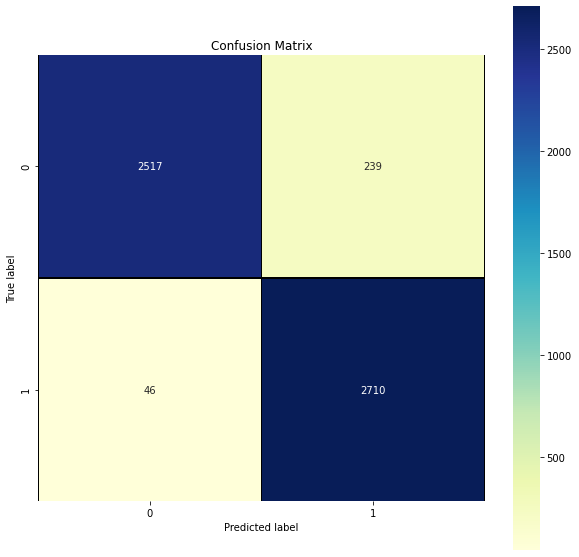

In [56]:
import seaborn as sns
# compute the confusion matrix
confusion_mtx=confusion_matrix(true_label_names, predictions)

# plot the confusion matrix
plt.figure(figsize=(10, 10)) #The size of plot chart
conf_plot=sns.heatmap(confusion_mtx, annot=True, fmt='d', linewidths=.1, linecolor='black', cmap="YlGnBu", square=True)

#set title and labels
conf_plot.set(xlabel="Predicted label", ylabel = 'True label', title='Confusion Matrix')

In [57]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
print('{} \n{} \n{}'.format(confusion_matrix(true_label_names, predictions) , 
                           classification_report(true_label_names, predictions) , 
                           accuracy_score(true_label_names, predictions)))

[[2517  239]
 [  46 2710]] 
              precision    recall  f1-score   support

 Parasitized       0.98      0.91      0.95      2756
  Uninfected       0.92      0.98      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512
 
0.9482946298984035


# Check the predictions




In [58]:
for image_batch, label_batch in validation_batches_generator:
    print('Data Batch Shape = {}'.format(data_batch.shape))
    print('Labels Batch Shape = {}'.format(label_batch.shape))
    break

Data Batch Shape = (32, 128, 128, 3)
Labels Batch Shape = (32,)


In [59]:
# Run the image batch through the model and convert the indices to class names.

predicted_batch = model.predict(image_batch)
predicted_labels = np.argmax(predicted_batch, axis=-1)
predicted_label_names = labels_names[predicted_labels]

In [60]:
predicted_batch

array([[9.98224199e-01, 1.77581422e-03],
       [9.99925971e-01, 7.40317555e-05],
       [9.95450318e-01, 4.54965793e-03],
       [9.96127069e-01, 3.87297850e-03],
       [9.53594625e-01, 4.64053974e-02],
       [9.41620529e-01, 5.83794899e-02],
       [9.55050766e-01, 4.49492000e-02],
       [9.96800900e-01, 3.19902645e-03],
       [9.87012684e-01, 1.29873436e-02],
       [9.88596618e-01, 1.14034498e-02],
       [1.58039376e-01, 8.41960669e-01],
       [9.99942422e-01, 5.75889026e-05],
       [9.99560297e-01, 4.39710042e-04],
       [9.98494744e-01, 1.50523172e-03],
       [9.69149113e-01, 3.08508165e-02],
       [9.99501705e-01, 4.98310488e-04],
       [9.99459088e-01, 5.40961337e-04],
       [9.99748886e-01, 2.51065387e-04],
       [9.87646461e-01, 1.23535600e-02],
       [9.97549832e-01, 2.45020003e-03],
       [9.97236192e-01, 2.76385807e-03],
       [9.90674078e-01, 9.32587124e-03],
       [9.99270380e-01, 7.29566091e-04],
       [9.99686599e-01, 3.13465804e-04],
       [8.623130

In [61]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [62]:
predicted_label_names

array(['Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Uninfected', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Parasitized', 'Parasitized'],
      dtype='<U11')

In [63]:
true_labels = label_batch.astype(int)
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
# no. of True classifed labels in that batch
print("The Number of Successfully classified Images:", sum(predicted_labels == true_labels))

The Number of Successfully classified Images: 31


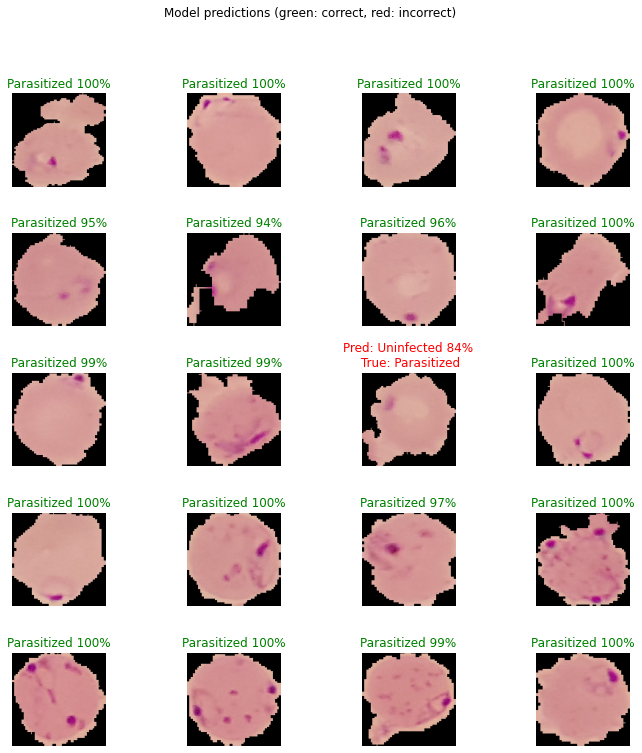

In [65]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(5,4,n+1)
  plt.imshow(image_batch[n])

  predict_for_n=predicted_batch[n]
  if predicted_labels[n] == true_labels[n]: 
    color = "green"
    plt.title("{} {:2.0f}%".format(predicted_label_names[n].title(), 100*np.max(predict_for_n)), color=color)
  else: 
    color= "red"
    plt.title("Pred: {} {:2.0f}%\n True: {}".format(predicted_label_names[n].title(), 100*np.max(predict_for_n), labels_names[true_labels[n]]), 
              color=color)

  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Save Model and weights

In [66]:
# Save the Model Weights
model.save('CNN_model_for_malaria.h5')

# Save the Model Weights
model.save_weights('model_weights_for_malaria.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('CNN_model_for_malaria.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the directory.')

Model saved to the directory.
